In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

100%|██████████| 5/5 [00:00<00:00, 29.51it/s]


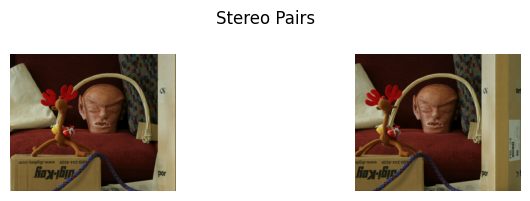

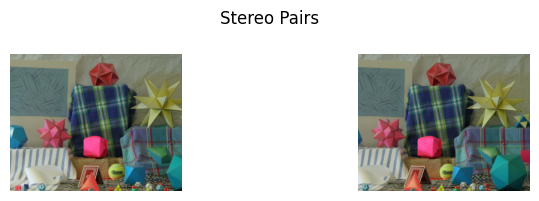

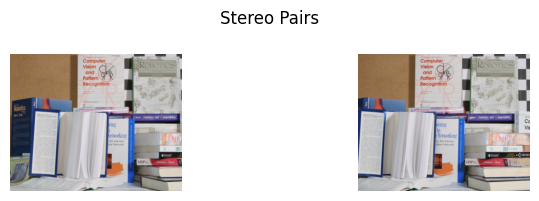

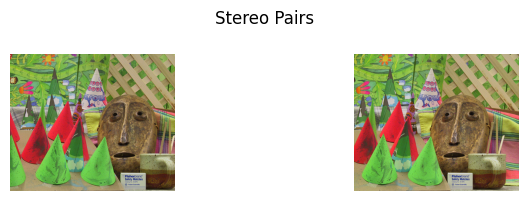

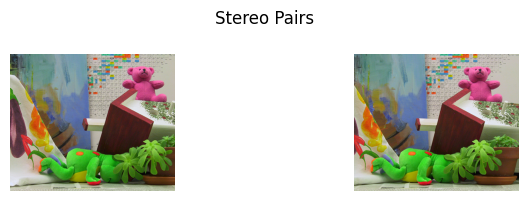

In [ ]:
# Loading all the images in the drive
pair_images = []

paths = natsorted(glob('/content/drive/My Drive/ES666CV/images/E/*'))

for idx in tqdm(range(0, len(paths), 2)):
    pair_images.append(np.array([cv2.imread(paths[idx], 1), cv2.imread(paths[idx+1], 1)]))

for pairs in pair_images:
    show_image_grid(pairs, 1, 2, 'Stereo Pairs', figsize=8)

### Reconstruction Algorithm

1. [Reconstruction](https://www.cs.cmu.edu/~16385/s15/lectures/Lecture19.pdf) [Must Read]

2. [Stereo and Disparity](https://johnwlambert.github.io/stereo/)

3. [Stereo and 3D Vision](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect16.pdf)

4. [Stereo Reconstruction](https://cs.nyu.edu/~fergus/teaching/vision/9_10_Stereo.pdf)

5. [Epipolar Geometry and the Fundamental Matrix](https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf)

Find the matching points between image pair. 

In [ ]:
def build_matching_point_pairs(image_a, image_b):

    gray_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2GRAY)
    gray_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    keypoints_a, descriptors_a = sift.detectAndCompute(gray_a, None)
    keypoints_b, descriptors_b = sift.detectAndCompute(gray_b, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors_a, descriptors_b, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    points_a = np.zeros((len(good_matches), 2), dtype=np.float32)
    points_b = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, match in enumerate(good_matches):
        points_a[i, :] = keypoints_a[match.queryIdx].pt
        points_b[i, :] = keypoints_b[match.trainIdx].pt

    # Draw matches on the images
    matching_img = cv2.drawMatches(image_a, keypoints_a, image_b, keypoints_b, good_matches, None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    show_image_grid(np.array([matching_img]), 1, 1, 'Feature Matches', figsize=12)

    return [points_a, points_b]

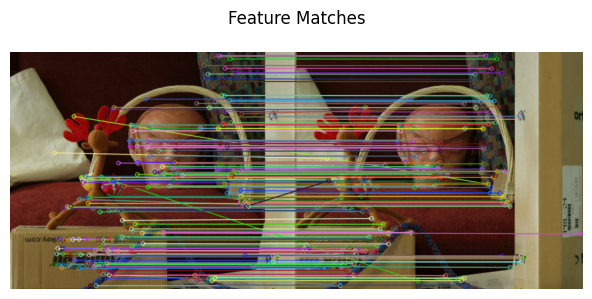

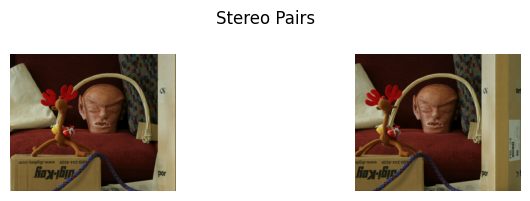

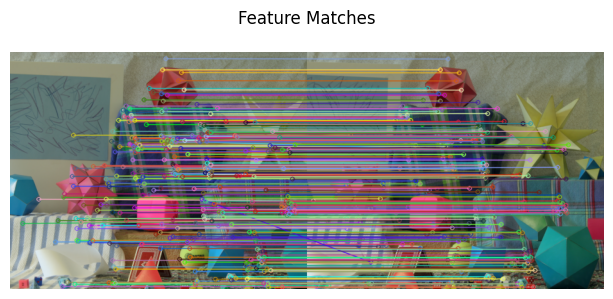

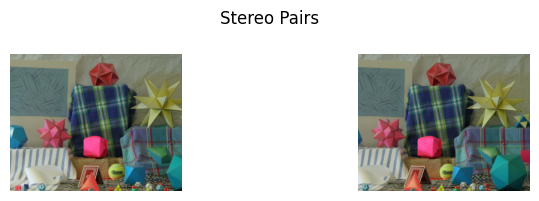

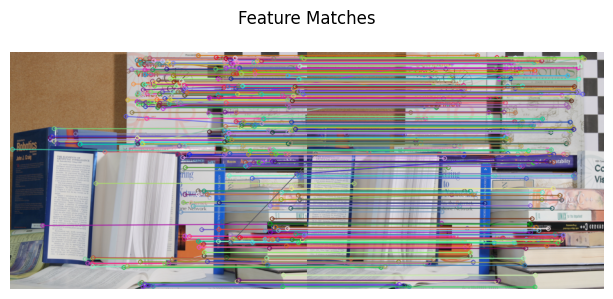

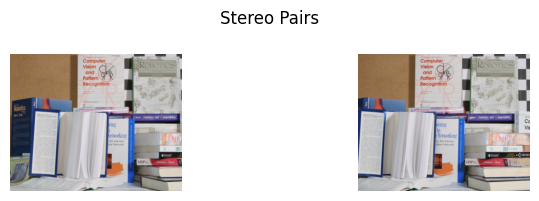

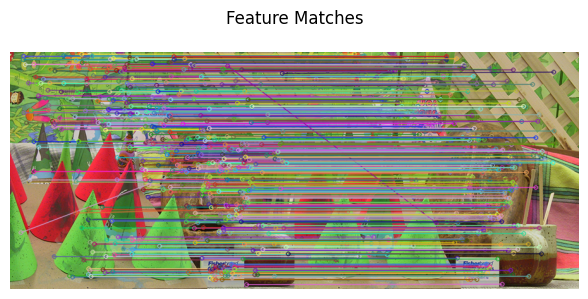

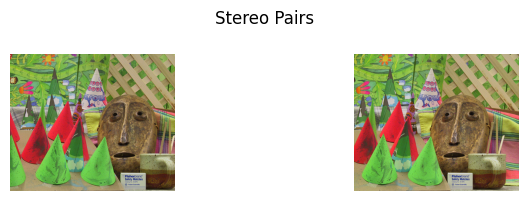

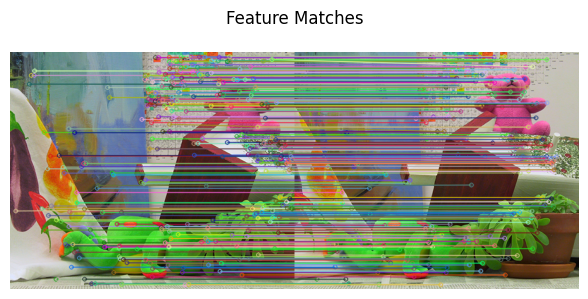

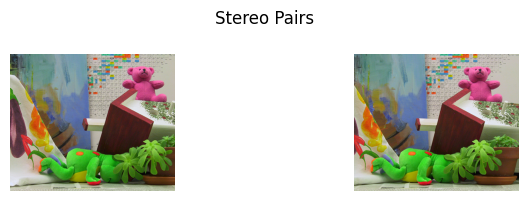

In [ ]:
global_matching_point_pair_lst = []
for pairs in pair_images:

    matching_points = build_matching_point_pairs(pairs[0], pairs[1])
    global_matching_point_pair_lst.append(matching_points)

    show_image_grid(np.array(pairs), 1, 2, 'Stereo Pairs', figsize=8)

Estimate the camera matrix [R | t] using matched points

In [ ]:
def estimate_camera_matrix(matching_point_a, matching_point_b):

    focal_length = 1
    principal_point = (0, 0)
    K = np.array([
        [focal_length, 0, principal_point[0]],
        [0, focal_length, principal_point[1]],
        [0, 0, 1]
    ])

    normalized_points_a = cv2.undistortPoints(matching_point_a.reshape(-1, 1, 2), K, None)
    normalized_points_b = cv2.undistortPoints(matching_point_b.reshape(-1, 1, 2), K, None)

    # Calculate essential matrix
    E, mask = cv2.findEssentialMat(
        normalized_points_a,
        normalized_points_b,
        focal=1.0,
        pp=(0., 0.),
        method=cv2.RANSAC,
        prob=0.999,
        threshold=0.001
    )

    inliers_a = normalized_points_a[mask.ravel() == 1]
    inliers_b = normalized_points_b[mask.ravel() == 1]

    # Recover R and t from essential matrix
    _, R, t, mask = cv2.recoverPose(
        E,
        inliers_a,
        inliers_b
    )

    # Construct the camera matrix [R|t]
    camera_matrix = np.hstack((R, t))  # 3x4 matrix

    print(f"Number of inliers: {np.sum(mask)}")
    print(f"Rotation matrix:\n{R}")
    print(f"Translation vector:\n{t}")

    return camera_matrix


In [ ]:
global_camera_matrix_lst = []
for matching_point_pair in global_matching_point_pair_lst:

    if len(matching_point_pair[0]) < 5:  # Need at least 5 points
        print("Not enough matching points for camera matrix estimation")
        camera_matrix = None
    else:
        camera_matrix = estimate_camera_matrix(
            matching_point_pair[0],
            matching_point_pair[1]
        )
    global_camera_matrix_lst.append(camera_matrix)


Number of inliers: 3315
Rotation matrix:
[[ 9.99997692e-01 -2.14824723e-03 -1.04937304e-05]
 [ 2.14824724e-03  9.99997693e-01  1.73971393e-06]
 [ 1.04899688e-05 -1.76225305e-06  1.00000000e+00]]
Translation vector:
[[-9.99985810e-01]
 [-5.32716870e-03]
 [-2.10626559e-05]]
Number of inliers: 3825
Rotation matrix:
[[ 9.99999602e-01 -8.91895609e-04 -3.73675666e-06]
 [ 8.91895656e-04  9.99999602e-01  1.26238946e-05]
 [ 3.72549597e-06 -1.26272224e-05  1.00000000e+00]]
Translation vector:
[[-9.99991355e-01]
 [ 4.15714300e-03]
 [ 9.48546781e-05]]
Number of inliers: 4080
Rotation matrix:
[[ 9.99999972e-01 -2.36896128e-04 -1.23308319e-07]
 [ 2.36896126e-04  9.99999972e-01 -1.19827564e-05]
 [ 1.26146985e-07  1.19827269e-05  1.00000000e+00]]
Translation vector:
[[-9.99974488e-01]
 [-7.14252268e-03]
 [-8.93855800e-05]]
Number of inliers: 5865
Rotation matrix:
[[ 9.99999998e-01  5.73974664e-05  4.25063916e-06]
 [-5.73974249e-05  9.99999998e-01 -9.76236336e-06]
 [-4.25119949e-06  9.76211937e-06  1.0

Stereo rectification based on the estimated camera matrix. This will help is algining the image pair which in turn help estimate disparity map easily.


In [ ]:
def perform_stereo_rectification(image_a, image_b, matching_point_a, matching_point_b, camera_matrix):

    h, w = image_a.shape[:2]

    # Define intrinsic matrix
    fx = fy = 1
    K = np.array([[fx, 0, w/2],
                  [0, fy, h/2],
                  [0, 0, 1]], dtype=np.float64)

    dist_coeffs = np.zeros((5, 1), dtype=np.float64)

    # Extract R and t from camera matrix
    R = camera_matrix[:, :3]
    t = camera_matrix[:, 3:]

    # Perform stereo rectification
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        K, dist_coeffs,
        K, dist_coeffs,
        (w, h),
        R, t,
        flags=cv2.CALIB_ZERO_DISPARITY,
        alpha=0
    )

    map1x, map1y = cv2.initUndistortRectifyMap(
        K, dist_coeffs, R1, P1,
        (w, h),
        cv2.CV_32FC1
    )

    map2x, map2y = cv2.initUndistortRectifyMap(
        K, dist_coeffs, R2, P2,
        (w, h),
        cv2.CV_32FC1
    )

    # Apply rectification
    img1_rectified = cv2.remap(
        image_a, map1x, map1y,
        cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )

    img2_rectified = cv2.remap(
        image_b, map2x, map2y,
        cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )

    # Draw horizontal lines to visualize rectification
    for i in range(0, h, 50):
        cv2.line(img1_rectified, (0, i), (w, i), (0, 255, 0), 1)
        cv2.line(img2_rectified, (0, i), (w, i), (0, 255, 0), 1)

    return [img1_rectified, img2_rectified]

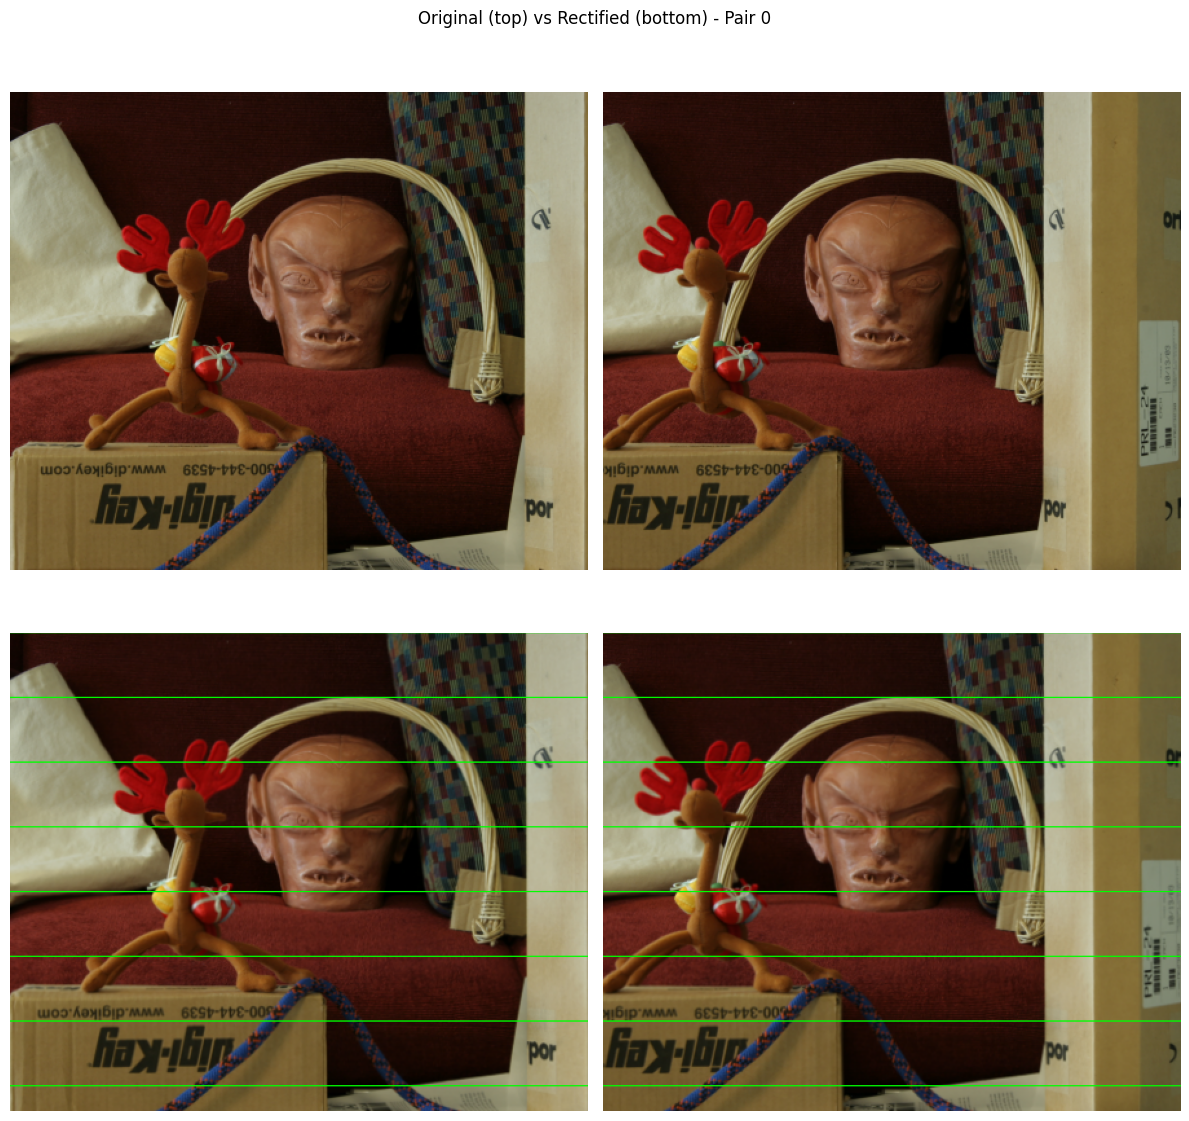

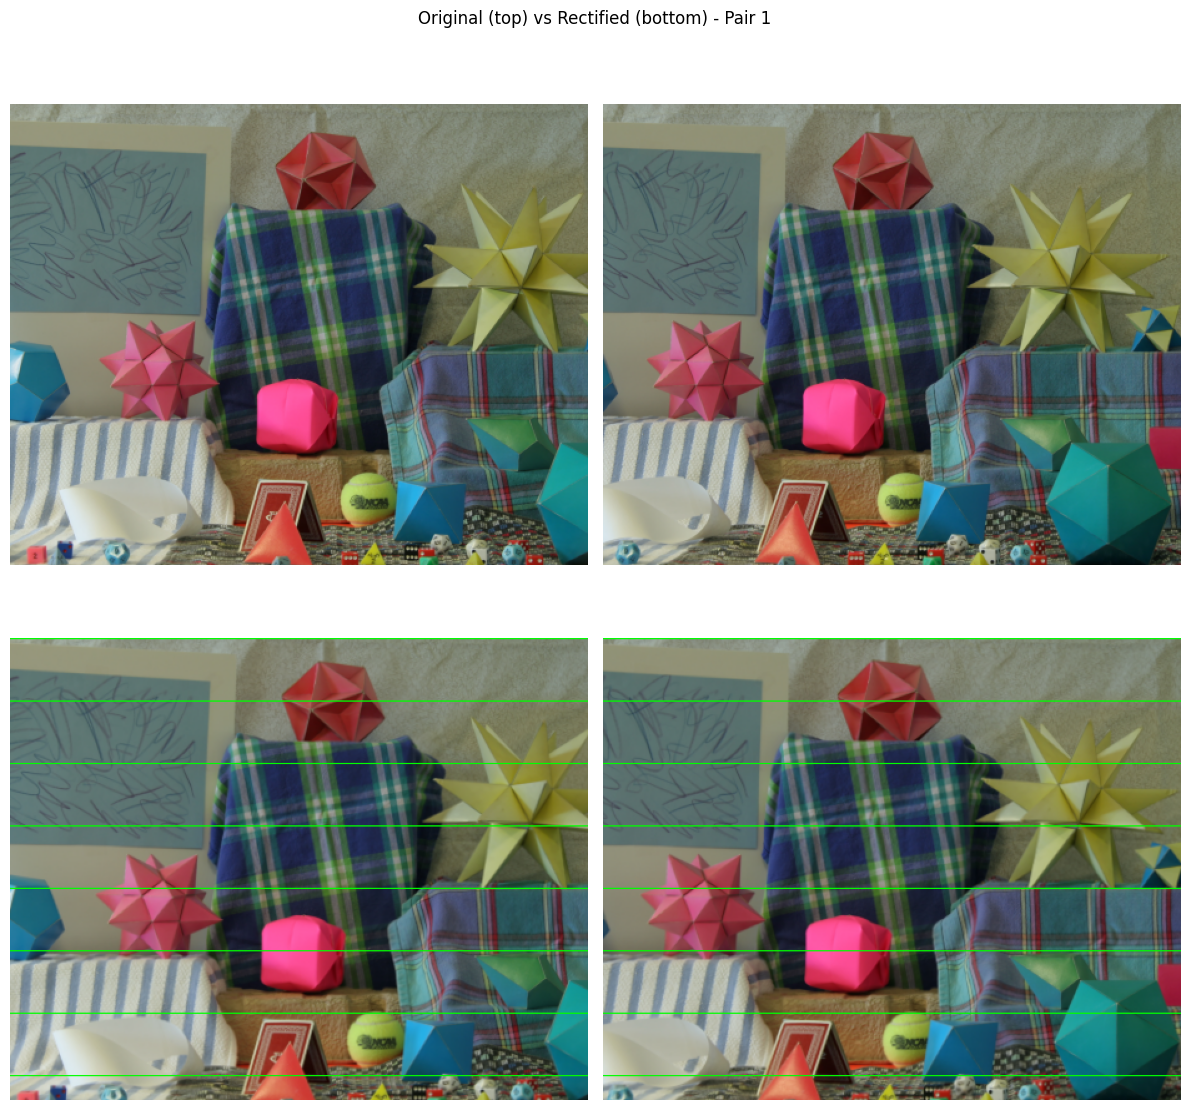

In [ ]:
N = len(pair_images) // 2  # Total stereo image pairs
rectified_pairs = []

for pair_idx in range(N):
    try:
        if global_camera_matrix_lst[pair_idx] is None:
            print(f"Skipping pair {pair_idx} due to invalid camera matrix")
            continue

        aligned_pairs = perform_stereo_rectification(
            pair_images[pair_idx][0],
            pair_images[pair_idx][1],
            global_matching_point_pair_lst[pair_idx][0],
            global_matching_point_pair_lst[pair_idx][1],
            global_camera_matrix_lst[pair_idx]
        )

        rectified_pairs.append(np.array(aligned_pairs))

        # Show original and rectified pairs side by side
        combined_display = np.array([
            pair_images[pair_idx][0], pair_images[pair_idx][1],  # Original pairs
            aligned_pairs[0], aligned_pairs[1]                    # Rectified pairs
        ])
        show_image_grid(combined_display, 2, 2,
                       f'Original (top) vs Rectified (bottom) - Pair {pair_idx}',
                       figsize=12)

    except Exception as e:
        print(f"Error processing pair {pair_idx}: {str(e)}")
        continue

Disparity maps for each pair using stereo rectification images.

In [ ]:
def compute_block_similarity(block1, block2):
    return np.sum(np.abs(block1 - block2))

In [ ]:
def disparity_map(image_a, image_b):

    if len(image_a.shape) == 3:
        image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2GRAY)
        image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)

    # Parameters
    block_size = 5  # Size of the matching block (odd number)
    max_disparity = 64  # Maximum disparity range
    min_disparity = 0

    height, width = image_a.shape
    half_block = block_size // 2

    # Initialize disparity map
    disp_map = np.zeros((height, width), dtype=np.float32)

    pad_width = ((half_block, half_block), (half_block, half_block))
    image_a_padded = np.pad(image_a, pad_width, mode='edge')
    image_b_padded = np.pad(image_b, pad_width, mode='edge')

    box_filter = np.ones((3, 3)) / 9.0

    print("Computing disparity map...")
    for y in range(half_block, height + half_block):
        for x in range(half_block, width + half_block):
            ref_block = image_a_padded[y-half_block:y+half_block+1,
                                     x-half_block:x+half_block+1]

            min_sad = float('inf')
            best_disparity = 0

            x_start = max(half_block, x - max_disparity)
            x_end = x - min_disparity

            for x_right in range(x_start, x_end + 1):
                target_block = image_b_padded[y-half_block:y+half_block+1,
                                            x_right-half_block:x_right+half_block+1]

                sad = compute_block_similarity(ref_block, target_block)

                if sad < min_sad:
                    min_sad = sad
                    best_disparity = x - x_right

            disp_map[y-half_block, x-half_block] = best_disparity

    disp_map = (disp_map * (255.0 / max_disparity)).astype(np.uint8)

    disp_map = convolve(disp_map, box_filter)

    disp_map = np.clip(disp_map, 0, 255)

    return disp_map

Processing pair 1/2
Computing disparity map...


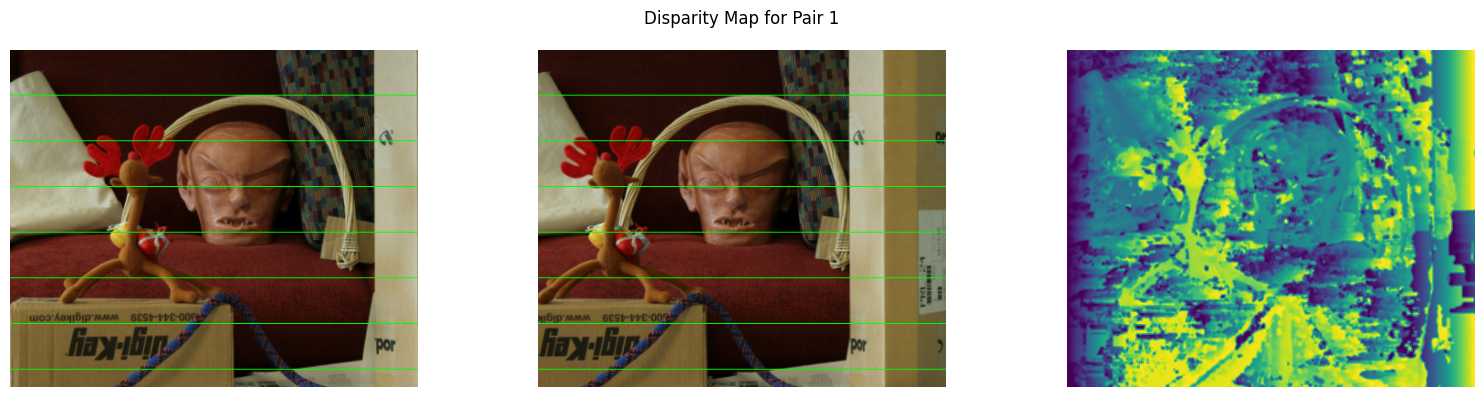

Processing pair 2/2
Computing disparity map...


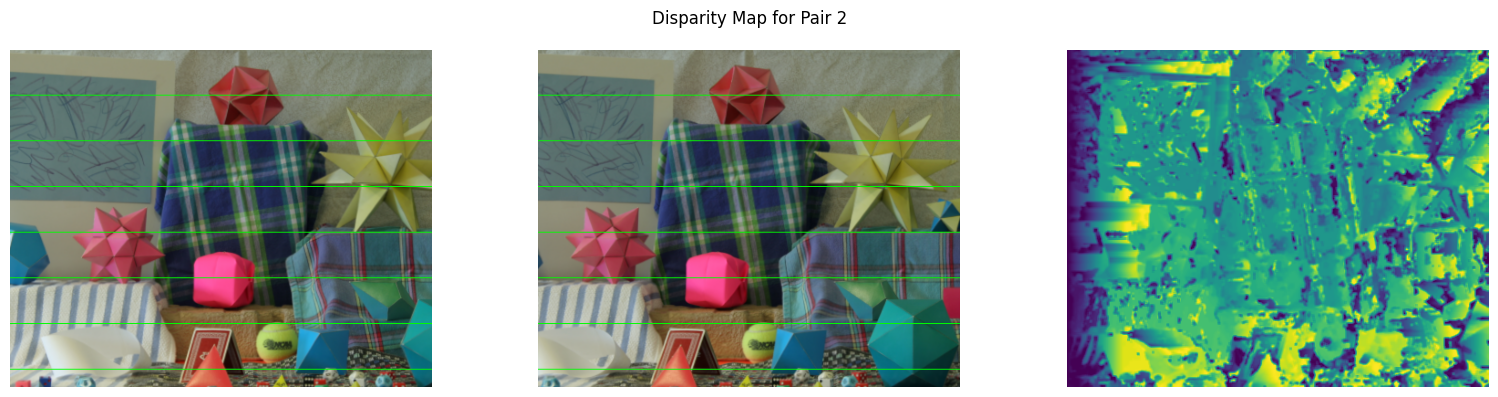

In [ ]:
for i, pairs in enumerate(rectified_pairs):
    print(f"Processing pair {i+1}/{len(rectified_pairs)}")

    # Compute disparity map
    disp_map = disparity_map(pairs[0], pairs[1])

    # Apply color mapping for visualization
    disp_color = cv2.applyColorMap(disp_map, cv2.COLORMAP_VIRIDIS)

    display_images = np.array([pairs[0], pairs[1], disp_color])
    show_image_grid(display_images, 1, 3, f'Disparity Map for Pair {i+1}', figsize=16)